In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.  

** *File and Data Field Descriptions* **

**train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.  
**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.  
**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.  
**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage.   **Passengers** in cryosleep are confined to their cabins.  
**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.  
**Destination** - The planet the passenger will be debarking to.  
**Age** - The age of the passenger.  
**VIP** - Whether the passenger has paid for special VIP service during the voyage.  
**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.  
**Name** - The first and last names of the passenger.  
**Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict  

**test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.  

**sample_submission.csv** - A submission file in the correct format.  
**PassengerId **- Id for each passenger in the test set.  
**Transported **- The target. For each passenger, predict either True or False.  

In [1]:
# Imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# Display input folder contents (data-sets()
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
# Read the training data into a pandas dataframe
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
print("Train shape is {}".format(train.shape))
print("Test shape is {}".format(test.shape))

Train shape is (8693, 14)
Test shape is (4277, 13)


In [3]:
# First 5 data entries
train.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [4]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
# Check NaN & Dupe values
print(train.isna().sum())
print("Dupes:", train.duplicated().sum()) # no dupes

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
Dupes: 0


In [7]:
train = train.drop(['PassengerId', 'Name'], axis=1)
train[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = train[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
train.isnull().sum().sort_values(ascending=False)

HomePlanet      201
Cabin           199
Destination     182
RoomService     181
Age             179
CryoSleep         0
VIP               0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64

<Axes: ylabel='count'>

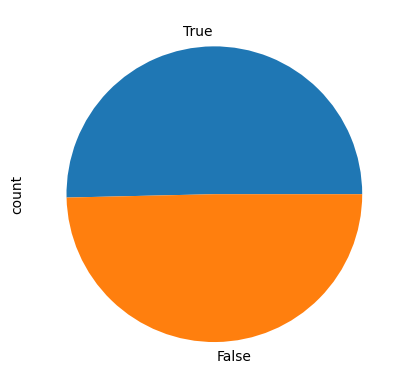

In [8]:
plot_train = train.Transported.value_counts()
plot_train.plot(kind="pie")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

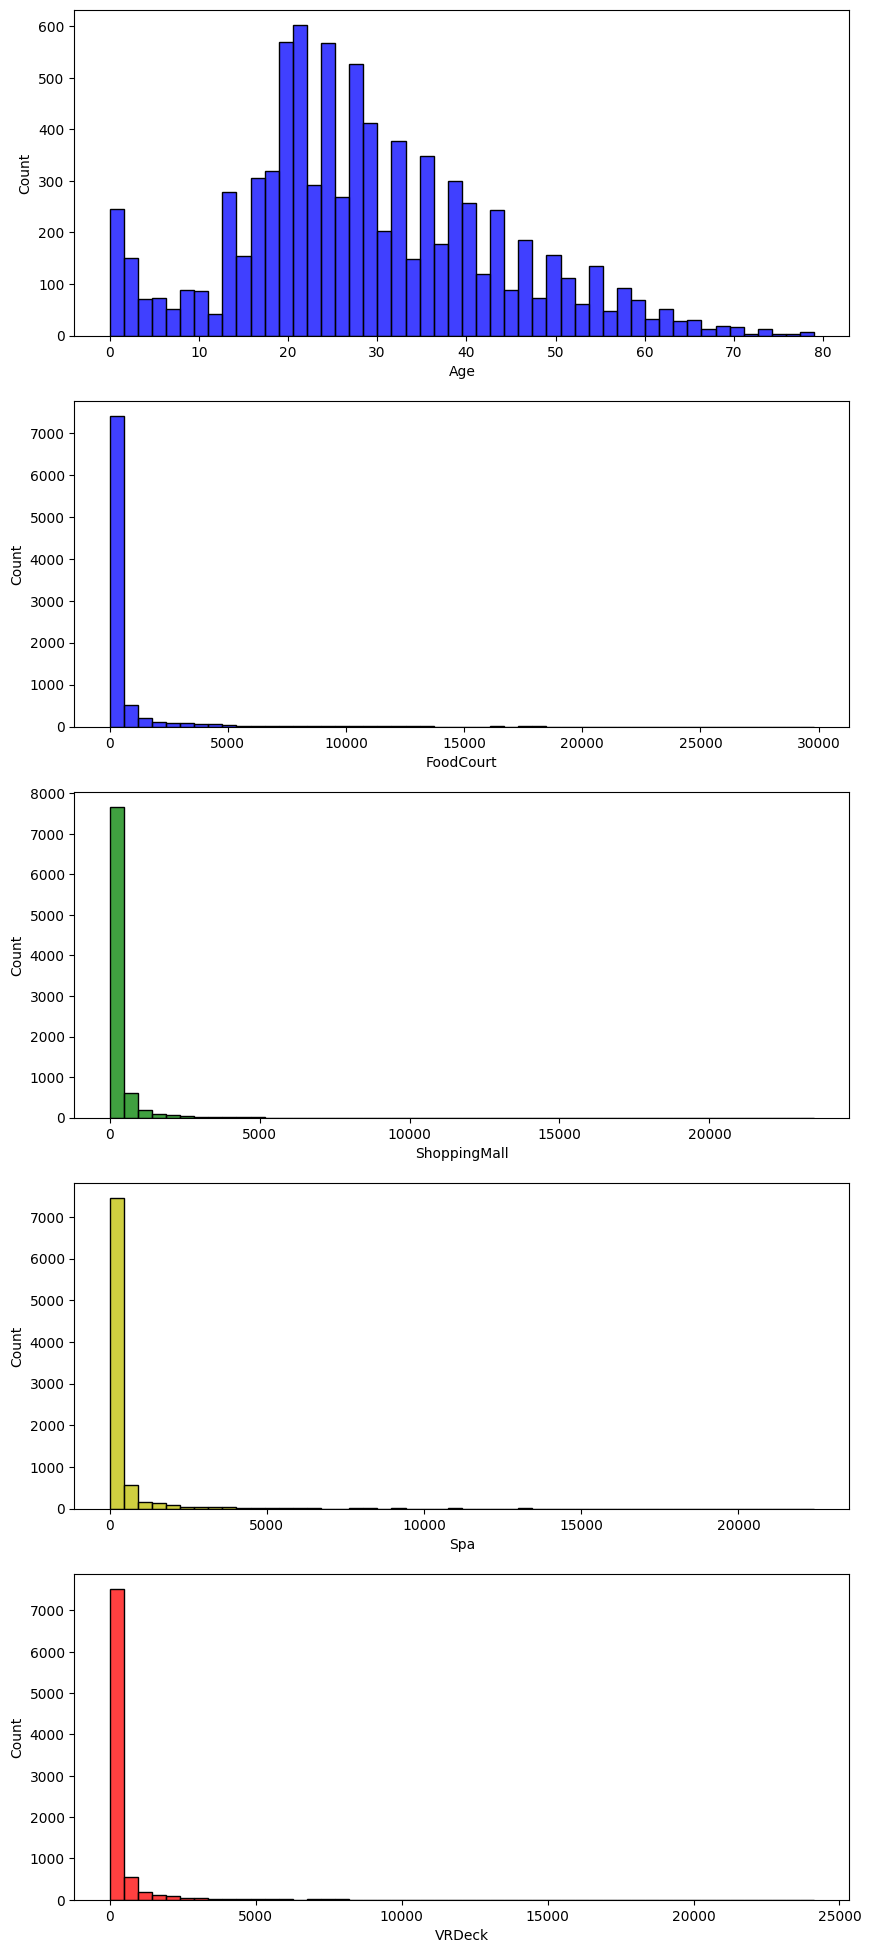

In [9]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(train['Age'], color='b', bins=50, ax=ax[0]);
sns.histplot(train['FoodCourt'], color='b', bins=50, ax=ax[1]);
sns.histplot(train['ShoppingMall'], color='g', bins=50, ax=ax[2]);
sns.histplot(train['Spa'], color='y', bins=50, ax=ax[3]);
sns.histplot(train['VRDeck'], color='r', bins=50, ax=ax[4]);

In [10]:
# Converting booleans to int
train["Transported"] = train["Transported"].astype(int)
train['VIP'] = train['VIP'].astype(int)
train['CryoSleep'] = train['CryoSleep'].astype(int)
train[["Deck", "Cabin_num", "Side"]] = train["Cabin"].str.split("/", expand=True) # Splitting col "Cabin" -> into 3 new cols


In [11]:
train = train.drop('Cabin', axis=1)
train = train.drop('Cabin_num', axis=1)

In [12]:
# 1-hot encoding categorial variables
train_encoded = pd.get_dummies(train, columns=["HomePlanet", 'Destination', 'Deck', 'Side'])

In [13]:
train_encoded.dropna(inplace=True)
train_encoded.info() # Checking the converted and cleaned data


<class 'pandas.core.frame.DataFrame'>
Index: 8334 entries, 0 to 8692
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8334 non-null   int64  
 1   Age                        8334 non-null   float64
 2   VIP                        8334 non-null   int64  
 3   RoomService                8334 non-null   float64
 4   FoodCourt                  8334 non-null   float64
 5   ShoppingMall               8334 non-null   float64
 6   Spa                        8334 non-null   float64
 7   VRDeck                     8334 non-null   float64
 8   Transported                8334 non-null   int64  
 9   HomePlanet_Earth           8334 non-null   bool   
 10  HomePlanet_Europa          8334 non-null   bool   
 11  HomePlanet_Mars            8334 non-null   bool   
 12  Destination_55 Cancri e    8334 non-null   bool   
 13  Destination_PSO J318.5-22  8334 non-null   bool   
 1

In [14]:
train_encoded = train_encoded.astype(int)
train_encoded.head(2)
print(f"Length of train_encoded dataset: {len(train_encoded)}")

Length of train_encoded dataset: 8334


In [15]:
train_arr = train_encoded.to_numpy()
test_arr = test.to_numpy()

print(train_arr)
print(test_arr)

[[ 0 39  0 ...  0  1  0]
 [ 0 24  0 ...  0  0  1]
 [ 0 58  1 ...  0  0  1]
 ...
 [ 0 26  0 ...  0  0  1]
 [ 0 32  0 ...  0  0  1]
 [ 0 44  0 ...  0  0  1]]
[['0013_01' 'Earth' True ... 0.0 0.0 'Nelly Carsoning']
 ['0018_01' 'Earth' False ... 2823.0 0.0 'Lerome Peckers']
 ['0019_01' 'Europa' True ... 0.0 0.0 'Sabih Unhearfus']
 ...
 ['9271_01' 'Mars' True ... 0.0 0.0 'Jayrin Pore']
 ['9273_01' 'Europa' False ... 0.0 523.0 'Kitakan Conale']
 ['9277_01' 'Earth' True ... 0.0 0.0 'Lilace Leonzaley']]


In [16]:
# Custom dataset class
class data(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        print(idx)
        return self.data[idx], self.labels[idx]

In [17]:
# Custom model class
class Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.output = nn.Linear(64, output_size)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.output(x)
        return x

In [18]:
# Data loaders
train_loader = DataLoader(train_arr, batch_size=2, shuffle=True)
test_loader = DataLoader(test_arr, batch_size=32, shuffle=False)

In [19]:
# Defining model, criterion & optimizer
model = Model(64, 64)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Learning rate